Learn the inter-grid prolongation operator (P) for single-phase problems using multigrid framework,
* Dataset is constructed by changing RHS (satisfy periodic compatibility condition)
* Restriction and Prolongation kernels are assumed to be the same (3x3)
* Learn the kernel for a single phase Poisson problem

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshSquare
from FEANet.jacobi import JacobiBlockPBC
from FEANet.model import KNet, FNet

from Utils import plot 
from Data.dataset import IsoPoissonPBCDataSet

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+3, n+3), requires_grad=False, dtype=torch.float32) # periodic rhs
        self.InstantiateFEANet()
        self.jac = JacobiBlockPBC(self.grid, self.Knet, self.omega)

    def IsCoarsest(self):
        return self.n == 2
        
    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, initial_v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = initial_v
        for i in range(num_sweeps_down):
            v = self.jac.jacobi_convolution(v, f)
        return v

In [3]:
n = 2**5
grid = SingleGrid(size=2,n=n)

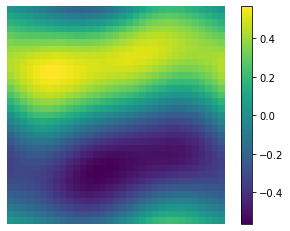

In [4]:
model_name = 'pbc_poisson_kernel_33x33'

training_set = IsoPoissonPBCDataSet('Data/IsoPoisson/poisson2d_33x33_pbc.h5')
train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
f_train = next(iter(train_dataloader))

k=0
plot.plot_field(f_train[k,0])

0 0.0425933301448822
1 0.04213837534189224
2 0.041689589619636536
3 0.04124682396650314
4 0.04080992937088013
5 0.04037877172231674
6 0.039953216910362244
7 0.03953314200043678
8 0.03911842778325081
9 0.03870896250009537
10 0.038304638117551804
11 0.03790535032749176
12 0.03751100227236748
13 0.037121497094631195
14 0.03673674538731575
15 0.03635665774345398
16 0.03598114848136902
17 0.0356101430952549
18 0.035243552178144455
19 0.03488130867481232
20 0.034523334354162216
21 0.03416955843567848
22 0.033819906413555145
23 0.03347431868314743
24 0.03313272446393967
25 0.03279506787657738
26 0.03246127441525459
27 0.03213129937648773
28 0.03180507570505142
29 0.03148254379630089
30 0.0311636533588171
31 0.030848348513245583
32 0.030536578968167305
33 0.03022829070687294
34 0.02992343343794346
35 0.02962196059525013
36 0.029323821887373924
37 0.029028967022895813
38 0.028737355023622513
39 0.02844894491136074
40 0.02816368266940117
41 0.027881531044840813
42 0.02760244533419609
43 0.027326

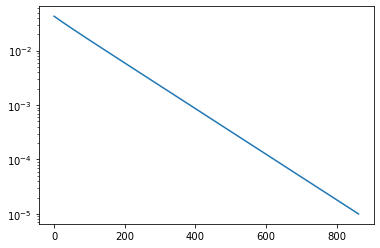

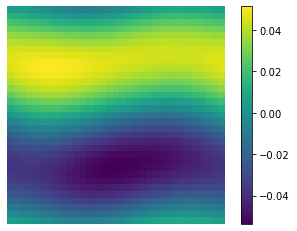

In [5]:
EPS = 1e-5
h = 2.0/n
n_jac = 0
u_jac = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
u_jac = grid.jac.reset_boundary(u_jac)
f_modify = f_train[k,0] - h*h*torch.sum(f_train[k,0][:-1,:-1])
f_jac = grid.fnet(grid.jac.pbc_boundary(f_modify.reshape((1,1,n+1,n+1)))) # assign the periodic rhs 
#f_jac = grid.fnet(grid.jac.pbc_boundary(f_train[k,0].reshape((1,1,n+1,n+1)))) # assign the periodic rhs 

u_jac_pbc = grid.jac.pbc_boundary(u_jac)
residual = f_jac-grid.Knet(u_jac_pbc)
res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
res_arr = [res]
while (abs(res) > EPS and n_jac < 1e4):
    u_jac = grid.Relax(u_jac, f_jac, 1)
    u_jac_pbc = grid.jac.pbc_boundary(u_jac)
    residual = f_jac-grid.Knet(u_jac_pbc)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')

print("Jacobi solution:")
plot.plot_field(u_jac.detach())

In [6]:
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0
linear_tensor_P

tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]])

In [7]:
class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, tensor_R):
        super(RestrictionNet, self).__init__()
        self.n_channel = 1
        self.net = nn.Conv2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][0][i] = tensor_R
            
    def forward(self, x_split):
        return self.net(x_split)


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, tensor_P):
        super(ProlongationNet, self).__init__()
        self.n_channel = 1
        self.net = nn.ConvTranspose2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][i][0] = tensor_P
            
    def forward(self, x_split): 
        return self.net(x_split)

In [8]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, linear_tensor_P):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        # Inter-grid communication network models
        self.conv = RestrictionNet(linear_tensor_P)
        self.deconv = ProlongationNet(linear_tensor_P)
        
        self.conv.requires_grad_(True)
        self.deconv.requires_grad_(False)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids        
            
    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted and periodically padded
        '''
        rC = self.conv(rF.clone())
        return rC

    def Interpolate(self, eC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eC has already been splitted
        '''
        eF = self.deconv(eC.clone())
        return eF 

    '''def loss(self, uk, k):
        "Compute the loss after k iterations, uk is current solution"
        u0_pbc = self.grids[0].jac.pbc_boundary(self.u0)
        uk_pbc = self.grids[0].jac.pbc_boundary(uk)
        resk = self.f - self.grids[0].Knet(uk_pbc)
        res0 = self.f - self.grids[0].Knet(u0_pbc)
        return torch.mean(torch.pow(torch.norm(resk[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res0[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach(), 1.0/k))
    '''
    def loss(self, uk, k):
        "Compute the loss after k iterations, uk is current solution"
        u0_pbc = self.grids[0].jac.pbc_boundary(self.last_v)
        u1_pbc = self.grids[0].jac.pbc_boundary(uk)
        res0 = self.f - self.grids[0].Knet(u0_pbc)
        res1 = self.f - self.grids[0].Knet(u1_pbc)
        return torch.mean(torch.norm(res1[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res0[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach())

    def forward(self, u0, f, k):
        '''Input is initial solution u0, RHS field f, iteration number k'''
        self.f = self.grids[0].fnet(self.grids[0].jac.pbc_boundary(f)) # assign the finest rhs 
        self.u0 = self.grids[0].jac.reset_boundary(u0) # reset the boundary of finest grid
        U = self.u0.clone()
        
        for i in range(k-1):
            U = self.iterate(U, self.f).detach()
        self.last_v = U.clone()
        return self.iterate(U, self.f)

    def iterate(self, x, f):
        ''' Input x is the initial solution on the finest grid; f is periodically padded '''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            v_pbc = self.grids[j].jac.pbc_boundary(self.grids[j].v)
            rF = self.grids[j].f-self.grids[j].Knet(v_pbc) 
            rF = self.grids[j].Knet.split_x(rF[:,:,1:-1,1:-1].clone()) 
            rF_pbc = self.grids[j].jac.pbc_boundary(rF)
            self.grids[j+1].f = self.grids[j+1].jac.pbc_boundary(self.Restrict(rF_pbc))
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)
        
        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].Knet.split_x(self.grids[j+1].v)
            eF_delta = self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v

In [9]:
def random_sampling(x):
    u = torch.randn_like(x)
    return u

In [10]:
model = MultiGrid(n, linear_tensor_P+0.5*torch.rand((3,3)))
model_linear = MultiGrid(n, linear_tensor_P)

0 0.04305462911725044
1 0.011452248319983482
2 0.003144117770716548
3 0.0008721425547264516
4 0.0002426947612548247
5 6.766289152437821e-05
6 1.888058068288956e-05
7 5.267805590847274e-06
Solution converges after 7 multi-grid iterations 


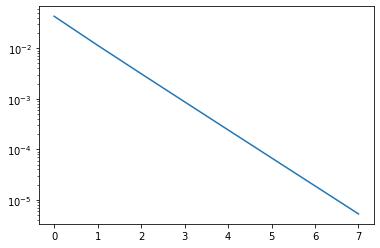

Multigrid solution:


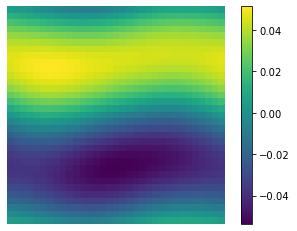

Jacobi solution:


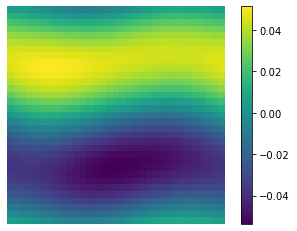

Error (jacobi v.s. mg):


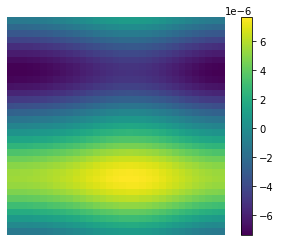

In [11]:
EPS = 1e-5
n_mg = 0
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
model_linear(u_mg, f_mg, 1) # initialize u and f for periodic boundary problems
u_mg = model_linear.u0

u0_pbc = model_linear.grids[0].jac.pbc_boundary(u_mg)
residual = model_linear.f-model_linear.grids[0].Knet(u0_pbc)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
res_arr = [res]
print(n_mg, res)
err_occured = False
while (abs(res) > EPS and n_mg < 1e2):
    u_mg = model_linear.iterate(u_mg, model_linear.f)
    u_pbc = model_linear.grids[0].jac.pbc_boundary(u_mg)
    residual = model_linear.f-model_linear.grids[0].Knet(u_pbc)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr.append(res)
    n_mg += 1
    print(n_mg, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Jacobi solution:")
plot.plot_field(u_jac.detach())

print("Error (jacobi v.s. mg):")
plot.plot_field(u_jac[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

In [13]:
model_dir = 'Model/iso_poisson'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mlist = list(model.parameters())
print('Restriction kernel:', mlist[0][0][0])
print('Restriction kernel shape:', mlist[0].shape)
print('Interpolation kernel:', mlist[1][0][0])
print('Interpolation kernel shape:', mlist[1].shape)

Restriction kernel: tensor([[0.4021, 0.5342, 0.6696],
        [0.5497, 1.1725, 0.8467],
        [0.6073, 0.5094, 0.3189]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 1, 3, 3])
Interpolation kernel: tensor([[0.4021, 0.5342, 0.6696],
        [0.5497, 1.1725, 0.8467],
        [0.6073, 0.5094, 0.3189]])
Interpolation kernel shape: torch.Size([1, 1, 3, 3])


In [14]:
def copy_kernels(para_list):
    '''Copy the values of R kernels to P kernels'''
    para_list[1][0,:] = para_list[0][:,0].detach()

In [15]:
def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        f_train = data
        
        optimizer.zero_grad() # zero the gradients for every batch
        k = random.randint(1,8)
        u0 = random_sampling(f_train)

        u_out = model(u0, f_train, k)
        loss_i = model.loss(u_out, k)
        
        loss_i.backward()
        para_list = list(model.parameters())
        optimizer.step()
        copy_kernels(para_list) # update the P kernels
        
        running_loss += loss_i.item()
    
    last_loss = running_loss/(i+1)
    return last_loss, para_list[0][0,0].data

In [16]:
num_epoch = 1000
best_vloss = 1_000_000.

loss_train = torch.zeros((num_epoch, 1))
kernel_train = torch.zeros((num_epoch, 3, 3))
for epoch in range(num_epoch):
    model.train(True)
    avg_loss, kernel_i = train_one_epoch()
    print(epoch, avg_loss)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,model_name+'.pth')
    torch.save(model.state_dict(), mpath)
    loss_train[epoch] = avg_loss
    kernel_train[epoch] = kernel_i.detach().clone()


0 7.4305827263742685
1 5.1575084533542395
2 3.5139641636051238
3 3.6351329535245895
4 3.1457312321290374
5 2.78407632233575
6 2.9222100330516696
7 2.6911039180122316
8 2.1813861234113574
9 2.4499468747526407
10 2.1707522007636726
11 2.630825450643897
12 1.2222843701019883
13 1.962649269029498
14 1.8779045408591628
15 1.7174320966005325
16 1.4927991963922977
17 1.356202364899218
18 1.8355729505419731
19 1.39177075214684
20 0.9616728723049164
21 1.3152272095903754
22 1.1431934079155326
23 1.0323424758389592
24 0.8358150967396796
25 0.9820656450465322
26 0.9078820929862559
27 0.8189030047506094
28 0.6894840658642352
29 0.5999417314305902
30 0.5716188340447843
31 0.45677274325862527
32 0.5785293141379952
33 0.5504711521789432
34 0.49453966645523906
35 0.6207936876453459
36 0.4981801793910563
37 0.4357278742827475
38 0.4233747851103544
39 0.32429164089262486
40 0.39775107940658927
41 0.4375903867185116
42 0.3398424186743796
43 0.3382435431703925
44 0.39928727969527245
45 0.27369160763919353

Average q:  tensor(0.1952) , STD:  tensor(0.0114)


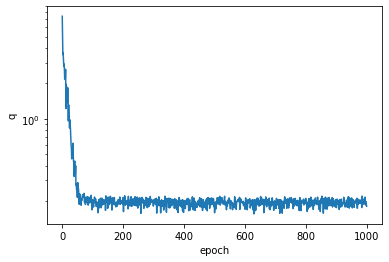

In [17]:
plt.plot(loss_train)
plt.ylabel('q')
plt.yscale('log')
plt.xlabel('epoch')
print("Average q: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

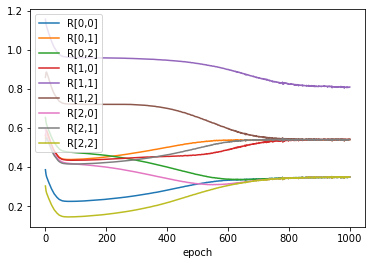

In [18]:
plt.plot(kernel_train[:,0,0], label="R[0,0]")
plt.plot(kernel_train[:,0,1], label="R[0,1]")
plt.plot(kernel_train[:,0,2], label="R[0,2]")
plt.plot(kernel_train[:,1,0], label="R[1,0]")
plt.plot(kernel_train[:,1,1], label="R[1,1]")
plt.plot(kernel_train[:,1,2], label="R[1,2]")
plt.plot(kernel_train[:,2,0], label="R[2,0]")
plt.plot(kernel_train[:,2,1], label="R[2,1]")
plt.plot(kernel_train[:,2,2], label="R[2,2]")
plt.xlabel('epoch')
plt.legend()

In [19]:
# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))
torch.save(kernel_train, os.path.join(model_dir,model_name+'-kernels.pt'))

In [20]:
# import the learned model
#model_name = 'poisson_mg_kernel_17x17'
Ps = torch.load(os.path.join(model_dir,model_name+'-kernels.pt'))
#P = torch.mean(Ps[-100:,:,:],dim=0)
P = Ps[-1,:,:]
print('Learned Restriction/Prolongation kernel:')
print(P)

Learned Restriction/Prolongation kernel:
tensor([[0.3506, 0.5427, 0.3514],
        [0.5436, 0.8112, 0.5436],
        [0.3512, 0.5427, 0.3512]])


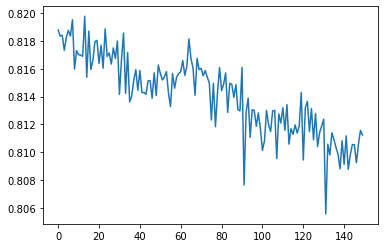

In [21]:
kernel_train = torch.load(os.path.join(model_dir,model_name+'-kernels.pt'))
plt.plot(kernel_train[-150:,1,1])

In [22]:
def compute_q(res_arr):
    return res_arr[-1]/res_arr[-2]

In [23]:
EPS = 1e-5
model = MultiGrid(n, P) # create a new model
n_mg = 0
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
model(u_mg, f_mg, 1) # initialize u and f for periodic boundary problems
u_mg = model.u0

u0_pbc = model.grids[0].jac.pbc_boundary(u_mg)
residual = model.f-model.grids[0].Knet(u0_pbc)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
err_occured = False
res_arr_learned = [res]
print(n_mg, res)
while (abs(res) > EPS and n_mg < 1e2):
    u_mg = model.iterate(u_mg, model.f)
    u_pbc = model.grids[0].jac.pbc_boundary(u_mg)
    residual = model.f-model.grids[0].Knet(u_pbc)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr_learned.append(res)
    n_mg += 1
    print(n_mg, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_mg, "multi-grid iterations ")
plt.plot(res_arr_learned, label='learned P')
plt.plot(res_arr, label='linear P')
plt.yscale('log')
plt.legend()
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

/tmp/ipykernel_4047104/892048246.py:5: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  f_mg = f_train[k,0].reshape((1,1,n+1,n+1))


RuntimeError: shape '[1, 1, 33, 33]' is invalid for input of size 7623

In [ ]:
k = []
k_learned = []
for i in range(len(res_arr)-1):
    k.append(res_arr[i+1]/res_arr[i])
    k_learned.append(res_arr_learned[i+1]/res_arr_learned[i])

plt.plot(k, label = 'linear')
plt.plot(k_learned, label='learned')
plt.legend()

In [ ]:
print("q is: ", compute_q(res_arr))
print("q hat is: " + str(float(model.loss(u_mg, len(res_arr)-1).detach())))

q is:  0.2788787527816918
q hat is: 3.0497825145721436
